In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:
%cd '/content/drive/MyDrive/DATA 245/Project'

/content/drive/.shortcut-targets-by-id/1dBaisw15vXAkSJcnz0pO83MeXqW6AHFn/DATA 245/Project


In [4]:
file_path = '02 artifacts/processed_dataset_WQ.pkl'
try:
    df_pickle = pd.read_pickle(file_path)
    print(f"Successfully read '{file_path}'")
    display(df_pickle.head())
except FileNotFoundError:
    print(f"File not found at {file_path}. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully read '02 artifacts/processed_dataset_WQ.pkl'


,station_id,station_name,station_number,full_station_name,station_type,latitude,longitude,county_name,sample_code,sample_date,...,Turbidity_NTU,WaterTemperature_°C,pH_pH units,qi_DO,qi_pH,qi_Cond,qi_Turb,qi_Temp,WQI,WQI_Class
0,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0114B0005,2014-01-06 12:14:00,...,2.28,10.18,7.60,87.000000,100.0,95.600000,97.72,50.90,89.854000,Good
1,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0115B0005,2015-01-05 11:53:00,...,1.41,10.75,7.91,83.857143,100.0,94.666667,98.59,53.75,89.183476,Good
2,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0117B0081,2017-01-10 14:00:00,...,160.00,9.24,7.26,93.142857,100.0,96.533333,0.00,46.20,71.869524,Moderate
3,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0118B0005,2018-01-08 11:40:00,...,3.00,10.80,8.36,79.428571,100.0,96.600000,97.00,54.00,87.948571,Good
4,1,AMERICAN,A0714010,American River at Water Treatment Plant,Surface Water,38.5596,-121.4169,Sacramento,C0119B0011,2019-01-07 14:15:00,...,2.10,11.00,7.71,81.857143,100.0,95.680000,97.90,55.00,88.773143,Good


In [5]:
df_pickle.columns

Index(['station_id', 'station_name', 'station_number', 'full_station_name',
       'station_type', 'latitude', 'longitude', 'county_name', 'sample_code',
       'sample_date', 'year', 'sample_depth_meter', 'DissolvedOxygen_mg/L',
       'SpecificConductance_µS/cm', 'Turbidity_NTU', 'WaterTemperature_°C',
       'pH_pH units', 'qi_DO', 'qi_pH', 'qi_Cond', 'qi_Turb', 'qi_Temp', 'WQI',
       'WQI_Class'],
      dtype='object')

In [6]:
feature_cols = [
    'DissolvedOxygen_mg/L',
    'SpecificConductance_µS/cm',
    'Turbidity_NTU',
    'WaterTemperature_°C',
    'pH_pH units',
    'sample_date',
    'sample_depth_meter',
    'latitude',
    'longitude'
]
df_reg = df_pickle[feature_cols]

In [7]:
def feature_engineering(df):
    df_preprocessed = df.copy()

    # 1. Setup Date and Location ID
    df_preprocessed['sample_date'] = pd.to_datetime(df_preprocessed['sample_date'])

    # Create a single ID column to make grouping easier
    df_preprocessed['location_id'] = df_preprocessed['latitude'].astype(str) + "_" + df_preprocessed['longitude'].astype(str)

    # 2. CRITICAL: Sort primarily by Location, then by Date
    # This ensures that when we .shift(1), we get the PREVIOUS day for the SAME station.
    df_preprocessed = df_preprocessed.sort_values(['location_id', 'sample_date']).reset_index(drop=True)

    # 4. Log Transforms
    df_preprocessed['log_SpecificConductance_µS/cm'] = np.log1p(df_preprocessed['SpecificConductance_µS/cm'])
    df_preprocessed['log_Turbidity_NTU'] = np.log1p(df_preprocessed['Turbidity_NTU'])

    # 5. Time Features
    df_preprocessed['Month'] = df_preprocessed['sample_date'].dt.month
    df_preprocessed['Month_sin'] = np.sin(2 * np.pi * df_preprocessed['Month']/12)
    df_preprocessed['Month_cos'] = np.cos(2 * np.pi * df_preprocessed['Month']/12)

    df_preprocessed['Hour'] = df_preprocessed['sample_date'].dt.hour

    # Add cyclical encoding for hour (23:00 is close to 00:00)
    df_preprocessed['Hour_sin'] = np.sin(2 * np.pi * df_preprocessed['Hour']/24)
    df_preprocessed['Hour_cos'] = np.cos(2 * np.pi * df_preprocessed['Hour']/24)

    # 6. Interactions
    df_preprocessed['Temp_x_Conductance'] = df_preprocessed['WaterTemperature_°C'] * df_preprocessed['SpecificConductance_µS/cm']
    df_preprocessed['Temp_x_MonthSin'] = df_preprocessed['WaterTemperature_°C'] * df_preprocessed['Month_sin']

    # 7. Time Gaps (Using location_id is cleaner than lat/long list)
    df_preprocessed['time_gap_days'] = df_preprocessed.groupby('location_id')['sample_date'].diff().dt.days

    # 8. Lag Features (Group by location_id)
    # Note: We use the LOG transformed columns for lags where available, as they might be more stable
    df_preprocessed['Lag_1_Conductance'] = df_preprocessed.groupby('location_id')['log_SpecificConductance_µS/cm'].shift(1)
    df_preprocessed['Lag_1_Turbidity'] = df_preprocessed.groupby('location_id')['log_Turbidity_NTU'].shift(1)
    df_preprocessed['Lag_1_Temperature'] = df_preprocessed.groupby('location_id')['WaterTemperature_°C'].shift(1)
    df_preprocessed['Lag_1_pH'] = df_preprocessed.groupby('location_id')['pH_pH units'].shift(1)
    df_preprocessed['Lag_1_DO'] = df_preprocessed.groupby('location_id')['DissolvedOxygen_mg/L'].shift(1)

    df_preprocessed['Rolling_Mean_3_DO'] = (
    df_preprocessed.groupby('location_id')['DissolvedOxygen_mg/L']
    .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).mean())
    )

    # Rolling Std Dev (captures "Volatility" - is the river stable or chaotic?)
    df_preprocessed['Rolling_Std_3_DO'] = (
        df_preprocessed.groupby('location_id')['DissolvedOxygen_mg/L']
        .transform(lambda x: x.shift(1).rolling(window=3, min_periods=1).std())
    ).fillna(0) # Std dev is NaN if only 1 sample exists

    # Remove the first row of every station (which are now NaNs due to shift)
    cols_with_lags = ['Lag_1_DO', 'Rolling_Mean_3_DO', 'time_gap_days']
    df_preprocessed = df_preprocessed.dropna(subset=cols_with_lags)

    df_preprocessed = df_preprocessed.drop(columns=['Month_cos',
                                                    'Month_sin',
                                                    'log_Turbidity_NTU',
                                                    'Temp_x_Conductance',
                                                    'location_id',
                                                    'Hour',
                                                    'Hour_cos',
                                                    'Lag_1_Conductance',
                                                    'log_SpecificConductance_µS/cm',
                                                    'Month'])

    return df_preprocessed


Average days between samples: 60.0
Median days between samples:  27.0


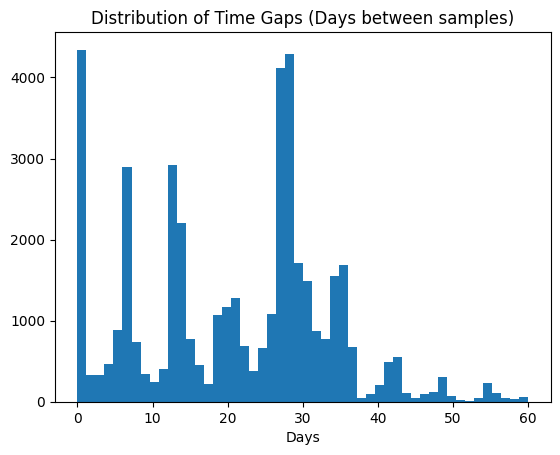

In [8]:
TARGET = 'DissolvedOxygen_mg/L'
drop_cols = [TARGET, 'sample_date']

df_reg = feature_engineering(df_reg)

df_reg['time_gap_days'] = df_reg.sort_values('sample_date').groupby(['latitude', 'longitude'])['sample_date'].diff().dt.days

# Check the average gap
avg_gap = df_reg['time_gap_days'].mean()
median_gap = df_reg['time_gap_days'].median()

print(f"Average days between samples: {avg_gap:.1f}")
print(f"Median days between samples:  {median_gap:.1f}")

# Visualize
import matplotlib.pyplot as plt
plt.hist(df_reg['time_gap_days'].dropna(), bins=50, range=(0, 60))
plt.title("Distribution of Time Gaps (Days between samples)")
plt.xlabel("Days")
plt.show()



In [9]:

X = df_reg.drop(columns=drop_cols + ['time_gap_days'])
y = df_reg[TARGET]

print(f"Data sorted by time. Shape: {X.shape}")

Data sorted by time. Shape: (52085, 15)


In [10]:
split_index = int(len(df_reg) * 0.80)

X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Training samples (Past): {len(X_train)}")
print(f"Testing samples (Future): {len(X_test)}")

Training samples (Past): 41668
Testing samples (Future): 10417


In [11]:
from scipy.stats import randint, uniform
def get_sample_weights(y):
    weights = np.ones_like(y)
    # Penalize errors on LOW DO (Hypoxia) 3x more
    weights[y < 4] = 10.0
    # Penalize errors on HIGH DO 2x more
    weights[y > 12] = 5.0
    return weights

train_weights = get_sample_weights(y_train)

model_choice = {
    'rf': RandomForestRegressor(random_state=42, n_jobs=1),
    'xgb': XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=1, tree_method='hist')
}

rf_params = {
    'model__n_estimators': randint(200, 1000),         # More trees (default is 100)
    'model__learning_rate': uniform(0.01, 0.1),        # Slower learning (default 0.3 is too fast)
    'model__max_depth': randint(4, 12),                # Deeper trees to catch interactions
    'model__subsample': uniform(0.6, 0.3),             # Fraction of data to train each tree (0.6-0.9)
    'model__colsample_bytree': uniform(0.6, 0.3),      # Fraction of features per tree
    'model__gamma': uniform(0, 0.5),                   # Regularization to prevent overfitting
    'model__reg_alpha': uniform(0, 0.5)                # L1 Regularization
}

xgb_params = {
    # Allow the model to create leaves for very small groups of data (CRITICAL for extremes)
    'model__min_child_weight': [1, 2], # Keep this LOW

    # Allow deeper trees to capture complex "if-then" rules for rare events
    'model__max_depth': randint(8, 15),

    # Reduce regularization so it doesn't punish the model for reacting to outliers
    'model__gamma': [0],               # Set to 0 to allow all splits
    'model__reg_alpha': [0, 0.01],     # Low L1 regularization

    # Keep learning rate low to learn slowly
    'model__learning_rate': uniform(0.01, 0.05),
    'model__n_estimators': randint(500, 1500)
}


In [12]:
model = 'xgb'

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5)),
    ('model', model_choice[model])
])

In [ ]:
# 1. Define TimeSeriesSplit (Expanding Window)
tscv = TimeSeriesSplit(n_splits=5)

# Before calling fit, ensure X_train and X_test contain only numerical data.
# The 'location_id' column is a string and will cause the StandardScaler to fail.
if 'location_id' in X_train.columns:
    X_train = X_train.drop(columns=['location_id'])
if 'location_id' in X_test.columns:
    X_test = X_test.drop(columns=['location_id'])

# 2. Randomized Search (More efficient than Grid Search)
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=xgb_params if model == 'xgb' else rf_params, # Corrected condition here
    n_iter=20, # Number of parameter settings to sample
    cv=tscv,   # Use Time Series Split here
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

fit_params = {
    'model__sample_weight': train_weights
}


# 3. Fit the model
print("Starting Hyperparameter Tuning...")
search.fit(X_train, y_train, **fit_params)

print(f"Best Parameters: {search.best_params_}")
best_model = search.best_estimator_

Starting Hyperparameter Tuning...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
# Predict on the held-out Test Set (The "Future" data)
y_pred = best_model.predict(X_test)

# Calculate Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("--- Final Test Set Performance ---")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")

# Visualizing Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual DO', alpha=0.7)
plt.plot(y_pred, label='Predicted DO', alpha=0.7)
plt.title("Dissolved Oxygen: Actual vs Predicted (Test Set)")
plt.xlabel("Time Steps")
plt.ylabel("DO (mg/L)")
plt.legend()
plt.show()

In [ ]:
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
plt.scatter(y_test, residuals, alpha=0.4)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Actual Dissolved Oxygen")
plt.ylabel("Error (Actual - Predicted)")
plt.title("Residuals vs Actuals")
plt.show()

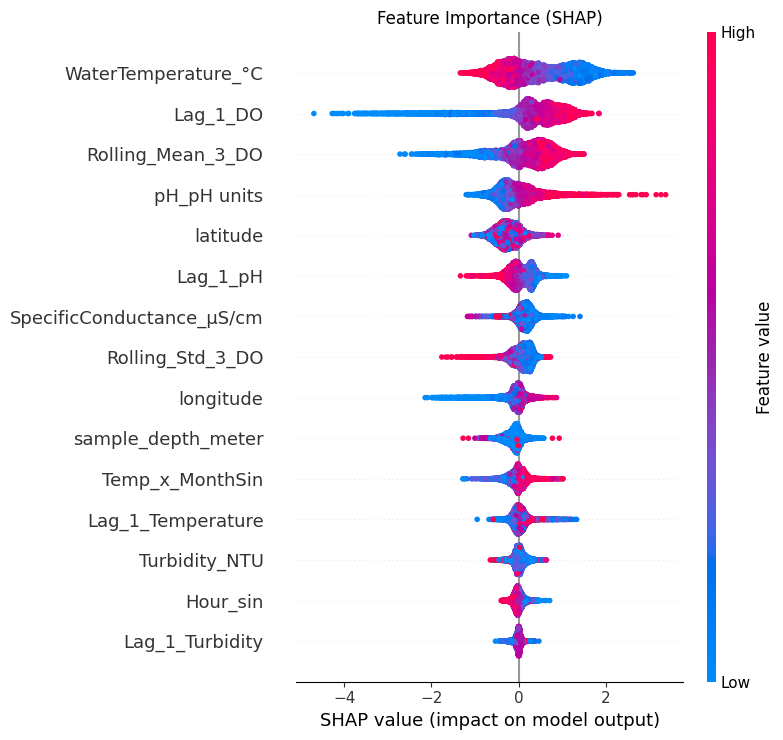

In [ ]:
import shap

# 1. Extract the actual model from the pipeline (last step)
final_regressor = best_model.named_steps['model']

# 2. Prepare background data for SHAP
# We must process X_test through the same scaler/imputer logic before explaining
X_test_processed = best_model.named_steps['scaler'].transform(X_test)
X_test_processed = best_model.named_steps['imputer'].transform(X_test_processed)

# 3. Create Explainer
explainer = shap.TreeExplainer(final_regressor)
shap_values = explainer.shap_values(X_test_processed)

# 4. Plot Feature Importance
plt.title("Feature Importance (SHAP)")
shap.summary_plot(shap_values, X_test_processed, feature_names=X.columns)

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

# 1. Choose the features you want to investigate
# Based on your SHAP plot, these are the most critical ones:
features_to_plot = [
    'WaterTemperature_°C',
    'Lag_1_pH',
    'Lag_1_DO',
    'Rolling_Mean_3_DO'
]

# 2. Create the plot
fig, ax = plt.subplots(figsize=(14, 4))
display = PartialDependenceDisplay.from_estimator(
    best_model,          # Your trained XGBoost/RF model
    X_train,             # The data to use for checking
    features_to_plot,
    kind="average",      # "average" shows the global trend
    n_cols=4,            # Arrange in one row
    ax=ax
)

plt.suptitle("Partial Dependence Plots: How each feature physically alters Dissolved Oxygen", y=1.05)
plt.show()